# Behavorial-Cloning Project
## - Brian Erickson
This is my implementation of the Udacity Self Driving Car class project "Behavioral Cloning".

The goal is to record driving input and images using a driving simulator, use the recorded input and images to train a neural network that will predict steering angles and then use the predicted steering angles to drive the same car in the same simulator.

Installation: This is a linux based implementation.  The linux simulator should be installed in ../simulator

### Imports and Helper Functions

The helper functions below will be used throughout the notebook.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
import math
import time
import skimage.transform
import random
import os
from ipywidgets import widgets
from IPython.display import display
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout, Flatten
from keras.layers import Dense, Lambda, SeparableConvolution2D, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.activations import relu, elu

%matplotlib inline

Using TensorFlow backend.


In [2]:
def plot_image(img,title=None):
    '''
    Plots a single RGB or Greyscale image with no border
    '''
    cmap = 'gray' if np.ndim(img) == 2 else None
    plt.axis('off')
    plt.imshow(img, cmap=cmap, interpolation='none')
    if title is not None:
        plt.title(title)
        
def plot_images(l, images_per_line = 10, image_size_inches = 1.0, title=None):
    """
    Plots images in a grid
    """
    fig=plt.figure()
    if title is not None:
        fig.suptitle(title)
    line_count=math.ceil(len(l)/images_per_line)
    fig.set_size_inches(w=images_per_line*image_size_inches,h=line_count*image_size_inches)
    for i in range(len(l)):
        img=l[i]
        plt.subplot(line_count,10,i+1)
        plot_image(img)


In [3]:
def elements_at_indexes(*lists, indexes):
    if len(lists)==1:
        l=lists[0]
        return [l[i] for i in indexes]
    else:
        return [elements_at_indexes(l,indexes=indexes) for l in lists]

# example usages
a = [2,4,6,10]
b = [3,6,9,12]
indexes = [1,3]
print (elements_at_indexes(a,b,indexes=indexes))
print (elements_at_indexes(a,indexes=indexes))



[[4, 10], [6, 12]]
[4, 10]


In [4]:
def split(*lists,n=None,ratio=None):
    if ratio is not None:
        n=int(len(lists[0])*ratio)
    rv = []
    for l in lists:
        rv.append(l[:n])
        rv.append(l[n:])
    return rv

In [5]:
def random_sample(*lists, n=None, ratio = None, return_remainder = False, random_order=True):
    """
    Returns parallel lists with n random samples from lists without replacement
    
    parameters
    ---
    n                   - number of samples to return in primary set
    ratio               - ratio of samples to return in primary set
                          if and and ratio ar both None, all samples are returned
    return_remainder    - returns two sets of lits, one with the n or 
                          ratio samples, the other with the remaining samples
    random_order        - if True, samples are returned in random order, otherwise
                          they are returned in the same order as in the original lists
    
    """
    list_length = len(lists[0])
    if n is None:
        n = list_length
    if n > list_length:
        n = list_length
        
    all_indexes = list(range(list_length))
    np.random.shuffle(all_indexes)
    i1,i2 = split(all_indexes, n=n, ratio=ratio)
    
    if random_order == False:
        i1.sort()
        i2.sort()
    rv  = []
    for l in lists:
        rv.append(elements_at_indexes(l,indexes=i1))
        if return_remainder:
            rv.append(elements_at_indexes(l,indexes=i2))
    
    return rv
        

In [6]:
# examples of random_sample
a=[1,2,3,4,5,6]
b=[2,4,6,7,10,12]
#print(random_sample(a,b,n=4,return_remainder=True))
print (random_sample(a,b))
print (random_sample(a,b,ratio=0.8,return_remainder=True))

[[1, 5, 6, 2, 4, 3], [2, 10, 12, 4, 7, 6]]
[[5, 6, 4, 2], [3, 1], [10, 12, 7, 4], [6, 2]]


In [7]:
def read_driving_log(folder='recordings'):
    csv_path = folder+'/driving_log.csv'
    csv_column_names = [
        'center',
        'left',
        'right',
        'steering',
        'throttle',
        'brake',
        'speed']
    
    return pd.read_csv(csv_path,names=csv_column_names,skiprows=1)

In [8]:
def read_logs():
    image_files = []
    steering_angles = []
    data_folder = '/home/brian/CarND/SimulatorData'
    for folder in os.listdir(data_folder):
        log_path = os.path.join(data_folder,folder)
        log = read_driving_log(log_path)
        new_filenames = ["/".join((log_path,"IMG",f.split("\\")[-1])) for f in log.center.values]
        image_files.extend(new_filenames)
        steering_angles.extend(log.steering.values)
    return image_files,steering_angles


In [9]:
X_path,y=read_logs()
X_train_path, X_val_path, y_train, y_val = \
   random_sample(X_path,y,random_order=False,return_remainder=True,ratio=0.8)

In [10]:
X_train_path_r,y_train_r = random_sample(X_train_path,y_train)

In [11]:
def pre_process_image(im):
    new_size=(im.shape[1]//2,im.shape[0]//2)
    small=cv2.resize(im,(new_size),interpolation=cv2.INTER_AREA)
    return  (cv2.cvtColor(small,cv2.COLOR_RGB2YUV).astype(float) - 128.)/255.


In [15]:
def test_generator():
    i = 0
    for (X,y) in generate_data_for_folder():
        plt.figure()
        plot_image(X, title=str(y))
        i+=1
        if i > 5:
            break

#test_generator()
    

In [16]:
def images_for_files(file_paths):
    images = []
    for f in file_paths:
        im=plt.imread(f)
        im=pre_process_image(im)
        images.append(im)
    np_images=np.array(images,dtype='float')
    del images
    return np_images

In [17]:
%%time
#X_train_r = images_for_files(X_train_path_r)
X_train = images_for_files(X_train_path)
X_val = images_for_files(X_val_path)

CPU times: user 15.1 s, sys: 1.31 s, total: 16.5 s
Wall time: 16.5 s


In [18]:
np.shape(X_train)

(5567, 80, 160, 3)

In [19]:
# let's remember the shape of the processed images
im_shape = X_train[0].shape
print(im_shape)

(80, 160, 3)


In [20]:

# manually transcribed and modified from 
# https://chatbotslife.com/learning-human-driving-behavior-using-nvidias-neural-network-model-and-image-augmentation-80399360efee#.u8zq6ghon

def RELU():
    return Activation(elu)

def nvidia_model(input_shape):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 -1., input_shape = input_shape))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
    model.add(RELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
    model.add(RELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
    model.add(RELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal"))
    model.add(RELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal"))
    model.add(Flatten())
    model.add(RELU())
    model.add(Dense(1164, init="he_normal"))
    model.add(RELU())
    model.add(Dense(100, init="he_normal"))
    model.add(RELU())
    model.add(Dense(50, init="he_normal"))
    model.add(RELU())
    model.add(Dense(10, init="he_normal"))
    model.add(RELU())
    model.add(Dense(1, init="he_normal"))
    return model



In [21]:
def model_a(im_shape):
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape=im_shape))
    model.add(SeparableConvolution2D(16, 3,3,  border_mode='valid', subsample=(2,2),activation='relu',name='conv1', dim_ordering='tf'))
    model.add(Convolution2D(32, 3, 3, border_mode='valid',  subsample=(2,2), activation='relu',name='conv2', dim_ordering='tf'))
    model.add(Convolution2D(64, 5, 5, border_mode='valid', activation='relu',name='conv3', dim_ordering='tf'))
    model.add(MaxPooling2D(pool_size=(4, 4), name ='maxpool2'))
    model.add(Flatten())
    model.add(Dense(100,activation='sigmoid',name='dense100'))
    model.add(Dense(20,activation='sigmoid',name='dense20'))
    model.add(Dropout(0.5, name ='dropout'))
    model.add(Dense(10,activation='sigmoid', name = 'dense10'))
    model.add(Dense(1,activation='linear', name = 'final'))
    return model

In [22]:
X_train[0:1].shape

(1, 80, 160, 3)

In [23]:
y_train=np.array(y_train)
y_val=np.array(y_val)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(5567, 80, 160, 3) (1392, 80, 160, 3) (5567,) (1392,)


In [24]:
#model = nvidia_model(im_shape)
model = model_a(im_shape)
model.compile(loss='mse', optimizer='adam')

In [25]:


history = model.fit(X_train, y_train,
    nb_epoch=100, batch_size=100,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint("best_model.h5"), EarlyStopping(patience=10)])


Train on 5567 samples, validate on 1392 samples
Epoch 1/100
5567/5567 [==============================] - 9s - loss: 0.0360 - val_loss: 0.0091
Epoch 2/100
5567/5567 [==============================] - 7s - loss: 0.0137 - val_loss: 0.0087
Epoch 3/100
5567/5567 [==============================] - 7s - loss: 0.0107 - val_loss: 0.0081
Epoch 4/100
5567/5567 [==============================] - 7s - loss: 0.0095 - val_loss: 0.0076
Epoch 5/100
5567/5567 [==============================] - 7s - loss: 0.0087 - val_loss: 0.0068
Epoch 6/100
5567/5567 [==============================] - 7s - loss: 0.0079 - val_loss: 0.0063
Epoch 7/100
5567/5567 [==============================] - 7s - loss: 0.0073 - val_loss: 0.0056
Epoch 8/100
5567/5567 [==============================] - 7s - loss: 0.0069 - val_loss: 0.0051
Epoch 9/100
5567/5567 [==============================] - 7s - loss: 0.0063 - val_loss: 0.0046
Epoch 10/100
5567/5567 [==============================] - 7s - loss: 0.0058 - val_loss: 0.0040
Epoch 11/10

In [26]:
y_train_predict=model.predict(X_train)
print(max(y_train), min(y_train), max(y_train_predict), min(y_train_predict))
print(np.mean(y_train),np.mean(y_train_predict))


0.3875669 -0.4944554 [ 0.28048098] [-0.30406335]
-0.0513608763025 -0.048487


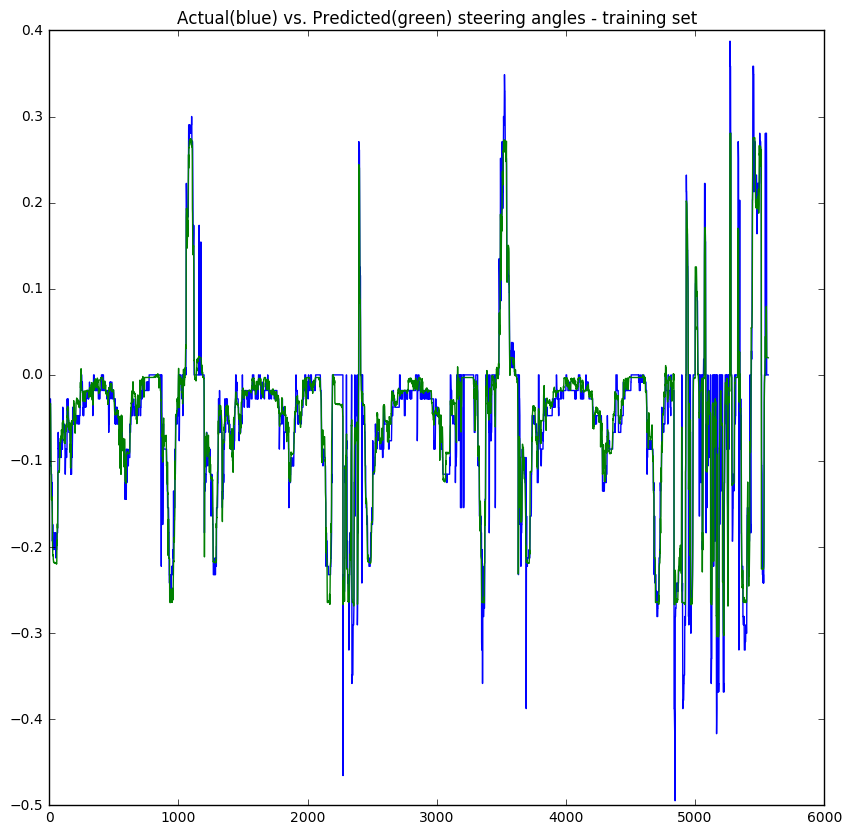

In [27]:

plt.figure(figsize=(10,10))
plt.plot(y_train,color='b')
plt.plot(y_train_predict,color='g')

plt.title("Actual(blue) vs. Predicted(green) steering angles - training set")

In [28]:
y_val_predict = model.predict(X_val)

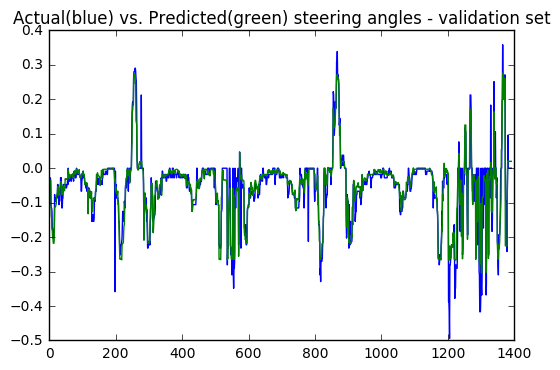

In [29]:
plt.plot(y_val, color='b')
plt.plot(y_val_predict, color='g')
plt.title("Actual(blue) vs. Predicted(green) steering angles - validation set")


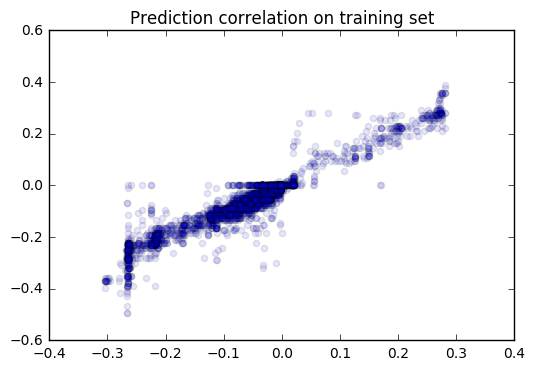

In [30]:
plt.scatter(y_train_predict,y_train,alpha=0.1)
plt.title("Prediction correlation on training set")

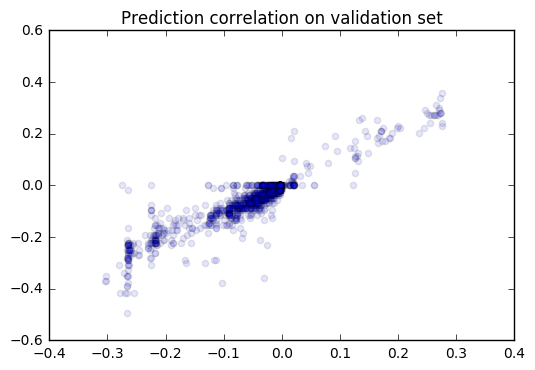

In [31]:
plt.scatter(y_val_predict,y_val,alpha=0.1)
plt.title("Prediction correlation on validation set")

In [32]:
#model.save('model_a_v00304.h5')
def save_model_to_json(model, file_path='model.json'):
    json = model.to_json()
    with open(file_path, 'w') as f:
        f.write(json)
        
def save_weights(model, file_path='model.h5'):
    model.save_weights(file_path)

def save_all():
    save_model_to_json(model)
    save_weights(model)



In [33]:
save_all()